# NMD on normalized counts

- NMD-3b & NMD-T
- Hyperparameter search (latent dimension & momentum parameter beta)
- on normalized counts

## Load libraries

Kernel dies if I execute the following:

import os
import sys
hashseed = os.getenv('PYTHONHASHSEED')
if not hashseed:
    os.environ['PYTHONHASHSEED'] = '0'
    os.execv(sys.executable, [sys.executable] + sys.argv)

In [1]:
#!pip install scanpy

In [2]:
# !pip install KDEpy

In [3]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot

import warnings
warnings.filterwarnings("ignore")

In [4]:
import importlib

## Preprocessing
### Read data

In [5]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [6]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

In [7]:
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)

print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


## Filter cells

Filter based on median absolute standard deviation:

- log1p_total_counts: count depth (number of counts per barcode)
- log1p_n_genes_by_counts: number of detected genes by barcode

Filter genes based on:
- min_cells = 2: at least gene is expressed in 2 cells

Further, filter cells based on:
- min_genes: at least 2 genes have to be expressed

In [8]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    1255
True       71
Name: outlier, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

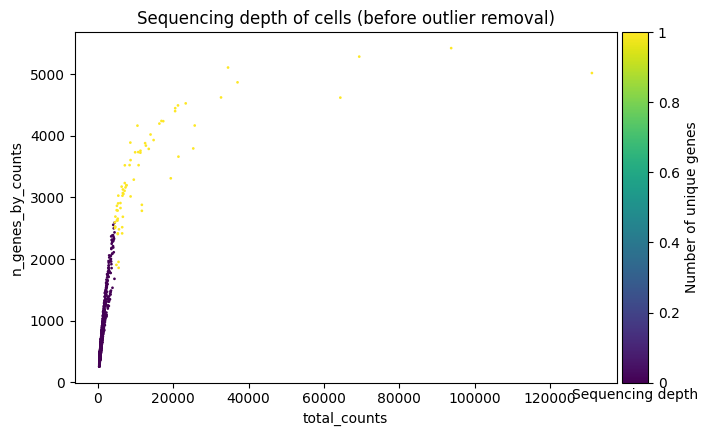

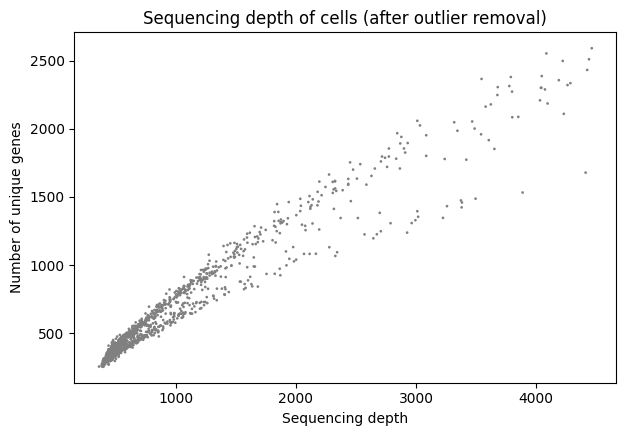

In [9]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [10]:
data_gene.layers["counts"] = data_gene.X.copy()

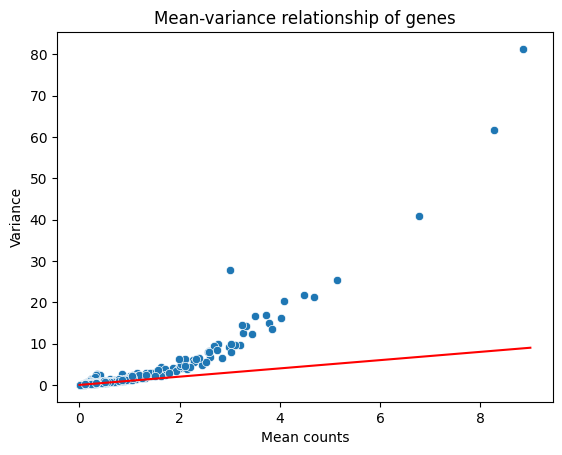

In [11]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [12]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="BFGS")
data_gene.var["nb_overdisp_cutoff_bfgs"] = data_gene.var["nb_overdisp_cutoff"]
data_gene.var["nb_overdisp_bfgs"] = data_gene.var["nb_overdisp"]


Fitting feature 100/5540
Fitting feature 200/5540
Fitting feature 300/5540
Fitting feature 400/5540
Fitting feature 500/5540
Fitting feature 600/5540
Fitting feature 700/5540
Fitting feature 800/5540
Fitting feature 900/5540
Fitting feature 1000/5540
Fitting feature 1100/5540
Fitting feature 1200/5540
Fitting feature 1300/5540
Fitting feature 1400/5540
Fitting feature 1500/5540
Fitting feature 1600/5540
Fitting feature 1700/5540
Fitting feature 1800/5540
Fitting feature 1900/5540
Fitting feature 2000/5540
Fitting feature 2100/5540
Fitting feature 2200/5540
Fitting feature 2300/5540
Fitting feature 2400/5540
Fitting feature 2500/5540
Fitting feature 2600/5540
Fitting feature 2700/5540
Fitting feature 2800/5540
Fitting feature 2900/5540
Fitting feature 3000/5540
Fitting feature 3100/5540
Fitting feature 3200/5540
Fitting feature 3300/5540
Fitting feature 3400/5540
Fitting feature 3500/5540
Fitting feature 3600/5540
Fitting feature 3700/5540
Fitting feature 3800/5540
Fitting feature 3900/

<Axes: xlabel='nb_mean', ylabel='Count'>

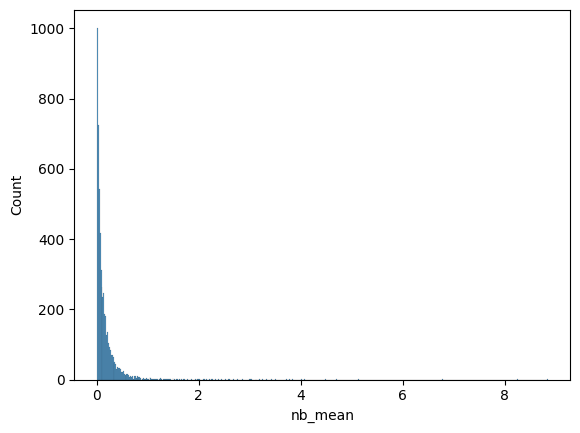

In [13]:
sns.histplot(data_gene.var["nb_mean"])

In [14]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

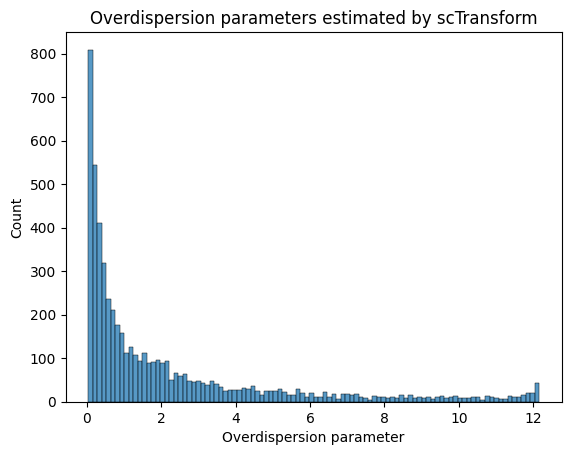

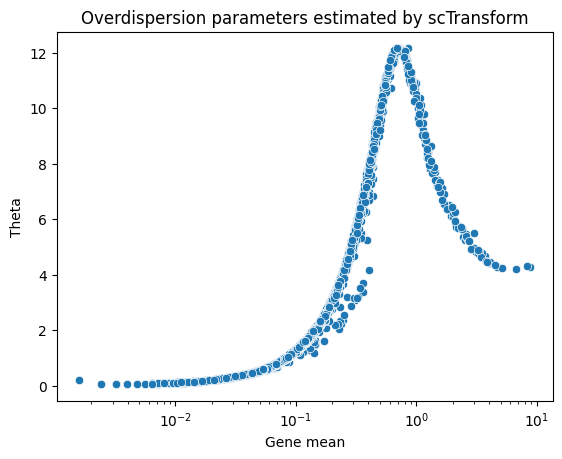

In [15]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

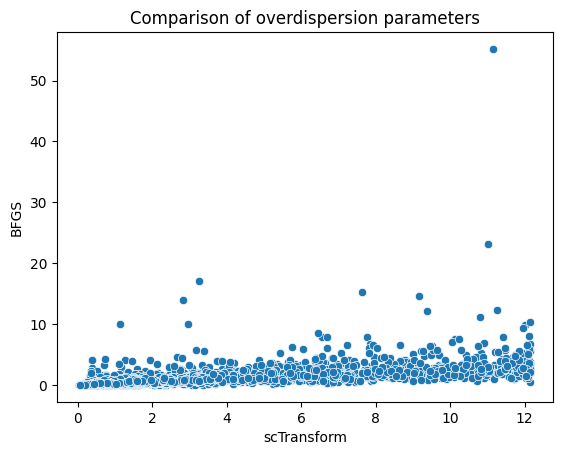

Correlation: [[1.         0.62839298]
 [0.62839298 1.        ]]


In [16]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

print(f"Correlation: {np.corrcoef(data_gene.var['nb_overdisp_cutoff_bfgs'], data_gene.var['nb_overdisp_cutoff'])}")

In [17]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [18]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)

# Only normalization
data_gene.layers["normalized_counts"] = data_gene.X.copy()

# Variance Stabilization Transformation
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()

#min_vst_counts = data_gene.layers["vst_counts"].min()

# Scale data to unit variance and zero mean. Truncate values to 10
#sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0

# Apply full PCA
sc.tl.pca(data_gene, svd_solver='arpack')

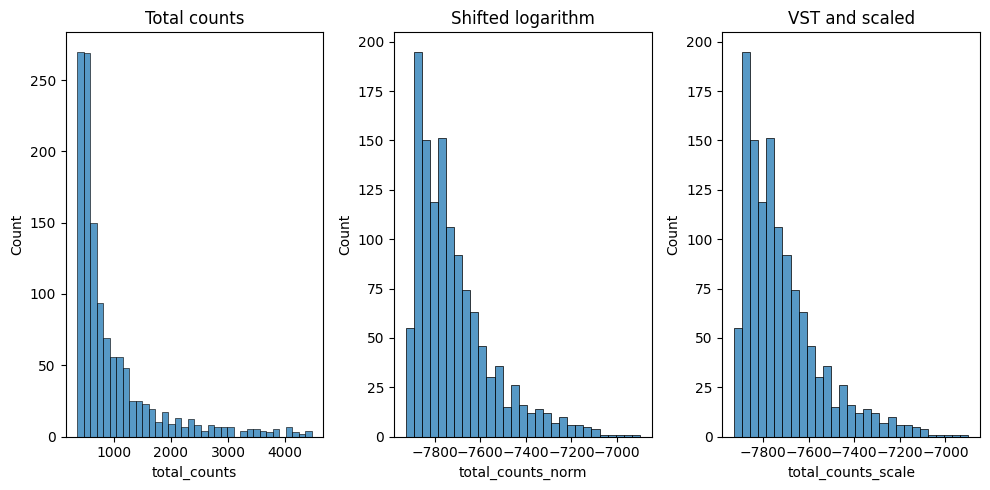

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [20]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1255 × 5419
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'


Transformation of train and test data

In [21]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=None, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# Variance Stabilization Transformation
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
data_train.layers["vst_counts_shifted"] = data_train.layers["vst_counts"].copy().todense() + data_train.layers["vst_counts"].min() * -1.

# test data
sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
data_test.layers["vst_counts_shifted"] = data_test.layers["vst_counts"].copy().todense() + data_test.layers["vst_counts"].min() * -1.

## Parameter search: NMD

In [22]:
importlib.reload(cs)

<module 'tools.countsplit' from '/dss/dsshome1/07/di35buw/NMD/BacSC_Moba/tools/countsplit.py'>

In [23]:
data_layer = "normalized_counts"

In [24]:
ks_2_check = [15, 12, 10, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.6, 0.7, 0.8, 0.9, 0.95]

In [25]:
select_cs_results = cs.select_nmd_t_params_countsplit(data_train, data_test, potential_ks=ks_2_check, potential_betas=betas_2_check, layer=data_layer)

################## LATENT DIM 15
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 12
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 10
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 8
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 7
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 6
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################

In [29]:
select_cs_results.sort_values(by="loss")

,k,beta,loss
50,1,0.60,5.183515e+02
51,1,0.70,5.185782e+02
52,1,0.80,5.200496e+02
42,3,0.80,5.249439e+02
40,3,0.60,5.251876e+02
41,3,0.70,5.252486e+02
48,2,0.90,5.269758e+02
43,3,0.90,5.281217e+02
47,2,0.80,5.284407e+02
46,2,0.70,5.290078e+02


<Axes: xlabel='k', ylabel='loss'>

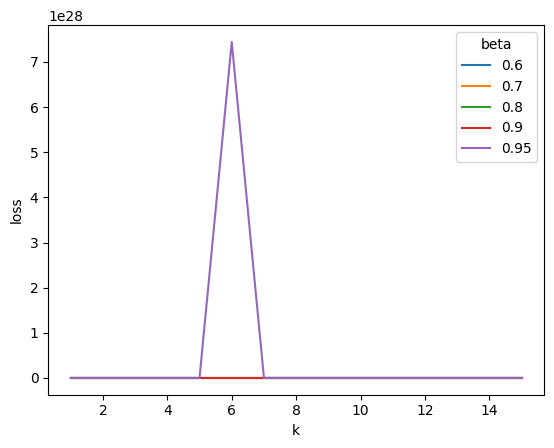

In [34]:
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")

<Axes: xlabel='k', ylabel='loss'>

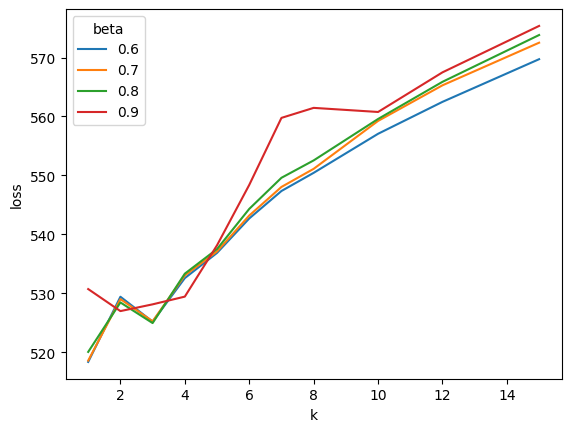

In [35]:
sns.lineplot(data=select_cs_results.loc[select_cs_results["beta"] < 0.95,:], x="k", y="loss", hue="beta", palette="tab10")

In [36]:
select_cs_3b_results = cs.select_3b_params_countsplit(data_train, data_test, potential_ks=ks_2_check, potential_betas=betas_2_check, layer=data_layer)

################## LATENT DIM 15
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 12
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 10
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 8
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 7
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## BETA 0.9
################## BETA 0.95
################## LATENT DIM 6
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################

In [81]:
select_cs_3b_results.sort_values(by="loss").head()

,k,beta,loss,algorithm
47,2,0.8,516.577716,3B-NMD
48,2,0.9,516.949495,3B-NMD
46,2,0.7,517.928061,3B-NMD
50,1,0.6,518.557711,3B-NMD
38,4,0.9,518.774600,3B-NMD


<Axes: xlabel='k', ylabel='loss'>

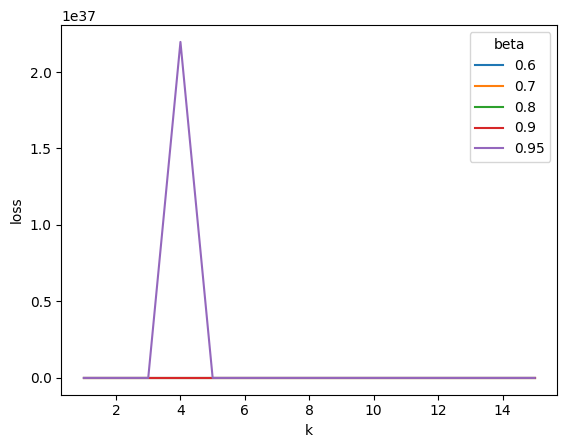

In [38]:
sns.lineplot(data=select_cs_3b_results, x="k", y="loss", hue="beta", palette="tab10")

<Axes: xlabel='k', ylabel='loss'>

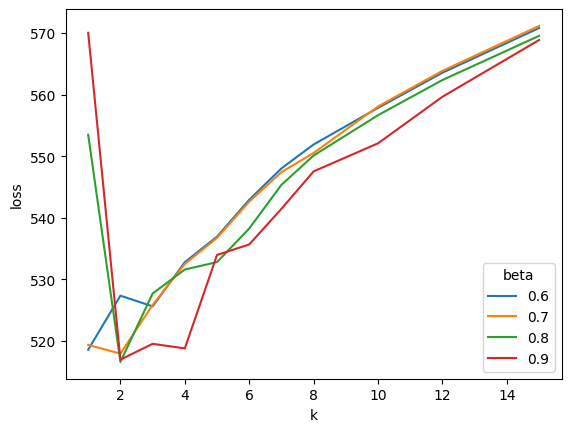

In [82]:
sns.lineplot(data=select_cs_3b_results.loc[select_cs_3b_results["beta"] < 0.95,:], x="k", y="loss", hue="beta", palette="tab10")

In [84]:
select_cs_3b_results["algorithm"] = "3B-NMD"
select_cs_results["algorithm"] = "NMD-T"

cs_param_search = pd.concat([select_cs_3b_results, select_cs_results], axis=0)
cs_param_search.sort_values(by="loss").head()

,k,beta,loss,algorithm
47,2,0.8,516.577716,3B-NMD
48,2,0.9,516.949495,3B-NMD
46,2,0.7,517.928061,3B-NMD
50,1,0.6,518.351522,NMD-T
50,1,0.6,518.557711,3B-NMD


In [40]:
# https://stackoverflow.com/questions/76404811/attributeerror-dataframe-object-has-no-attribute-iteritems
pd.DataFrame.iteritems = pd.DataFrame.items 

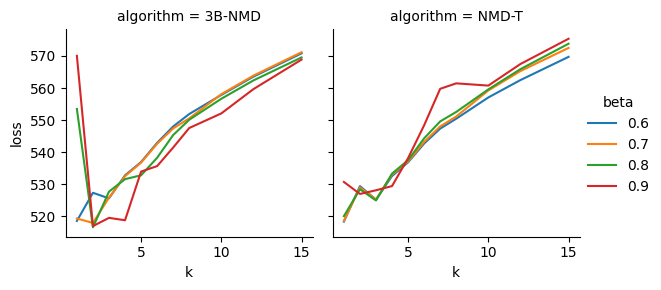

In [85]:
g = sns.FacetGrid(data=cs_param_search.loc[cs_param_search["beta"] < 0.95,:], col="algorithm", hue="beta", palette="tab10")
g.map(sns.lineplot, "k", "loss")
g.add_legend()
plt.show()

In [86]:
cs_param_search.sort_values(by="loss").head(15)

,k,beta,loss,algorithm
47,2,0.8,516.577716,3B-NMD
48,2,0.9,516.949495,3B-NMD
46,2,0.7,517.928061,3B-NMD
50,1,0.6,518.351522,NMD-T
50,1,0.6,518.557711,3B-NMD
51,1,0.7,518.578209,NMD-T
38,4,0.9,518.774600,3B-NMD
51,1,0.7,519.335499,3B-NMD
43,3,0.9,519.519048,3B-NMD
52,1,0.8,520.049649,NMD-T


## NMD 3-B

In [43]:
from tools import NMD as nmd

In [44]:
k_opt_3b = 2
beta_opt_3b = 0.8
data_layer = "normalized_counts"

In [45]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X_nmd, m, n, k_opt_3b)
Theta0 = W0 @ H0

In [46]:
Theta_3b, W_3b, H_3b, loss_3b, iters_3b, times_3b = nmd.nmd_3b(X_nmd, r=k_opt_3b, W0=W0, H0=H0, beta1=beta_opt_3b, tol_over_10iters=1e-5)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 74.662229] - 0.309414 secs
[1 : 74.123925] - 0.311775 secs
[2 : 73.712822] - 0.308583 secs
[3 : 73.582557] - 0.311731 secs
[4 : 73.531496] - 0.311741 secs
[5 : 73.376746] - 0.309153 secs
[6 : 73.257210] - 0.311170 secs
[7 : 73.213911] - 0.314578 secs
[8 : 73.197725] - 0.307875 secs
[9 : 73.187726] - 0.313223 secs
[10 : 73.179608] - 0.312379 secs
[11 : 73.173781] - 0.306587 secs
[12 : 73.170686] - 0.310587 secs
[13 : 73.168530] - 0.310479 secs
[14 : 73.166571] - 0.303027 secs
[15 : 73.164816] - 0.305988 secs
[16 : 73.163626] - 0.310253 secs
[17 : 73.162876] - 0.307757 secs
[18 : 73.162328] - 0.310400 secs
[19 : 73.161867] - 0.309134 secs
[20 : 73.161508] - 0.305929 secs
[21 : 73.161130] - 0.308266 secs
[22 : 73.160807] - 0.310518 secs
[23 : 73.160508] - 0.305265 secs
[24 : 73.160206] - 0.306647 secs
[25 : 73.159855] - 0.308527 secs
[26 : 73.159468] - 0.305621 secs
[27 : 73.159040] - 0.308354 

[242 : 72.143971] - 0.307491 secs
[243 : 72.137367] - 0.315713 secs
[244 : 72.132549] - 0.310751 secs
[245 : 72.128847] - 0.305624 secs
[246 : 72.125921] - 0.308331 secs
[247 : 72.123594] - 0.311658 secs
[248 : 72.121699] - 0.305191 secs
[249 : 72.120106] - 0.307660 secs
[250 : 72.118761] - 0.310967 secs
[251 : 72.117589] - 0.308312 secs
[252 : 72.116586] - 0.309583 secs
[253 : 72.115710] - 0.309768 secs
[254 : 72.114907] - 0.303388 secs
[255 : 72.114187] - 0.306874 secs
[256 : 72.113553] - 0.309625 secs
[257 : 72.113017] - 0.305374 secs
[258 : 72.112518] - 0.309294 secs
[259 : 72.112042] - 0.308754 secs
[260 : 72.111612] - 0.305136 secs
[261 : 72.111238] - 0.308697 secs
[262 : 72.110909] - 0.312411 secs
[263 : 72.110609] - 0.305096 secs
[264 : 72.110338] - 0.305613 secs
[265 : 72.110097] - 0.309286 secs
[266 : 72.109888] - 0.312866 secs
[267 : 72.109697] - 0.311225 secs
[268 : 72.109521] - 0.308726 secs
[269 : 72.109353] - 0.307138 secs
[270 : 72.109190] - 0.308908 secs
[271 : 72.1090

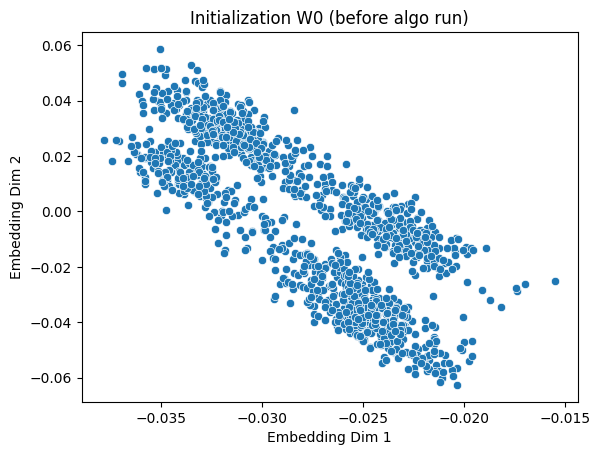

In [47]:
sns.scatterplot(x=W0[:,0], y=W0[:,1]).set(title="Initialization W0 (before algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

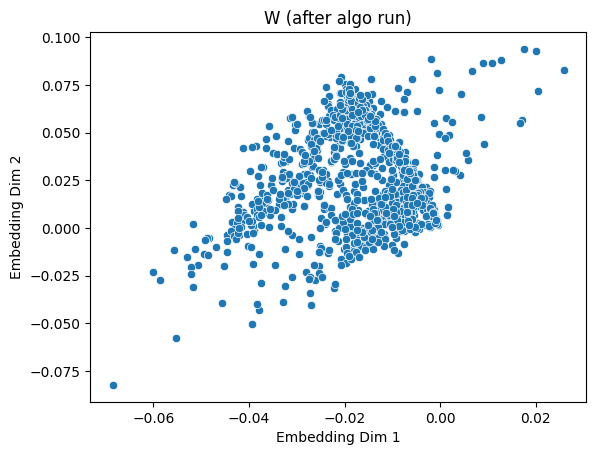

In [48]:
sns.scatterplot(x=W_3b[:,0], y=W_3b[:,1]).set(title="W (after algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

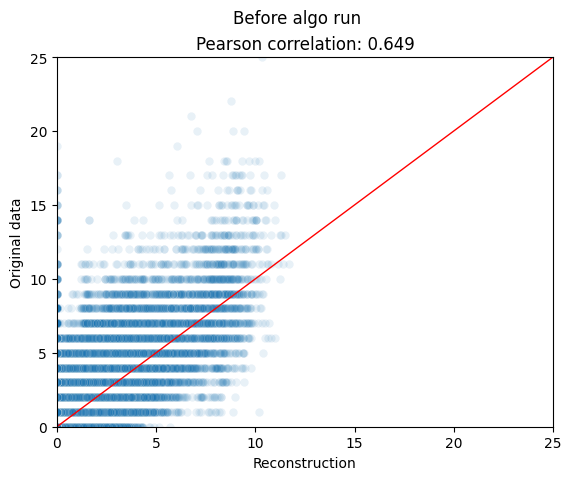

In [49]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta0), X_nmd, "Before algo run", type="scatter", sample_fraction=None)

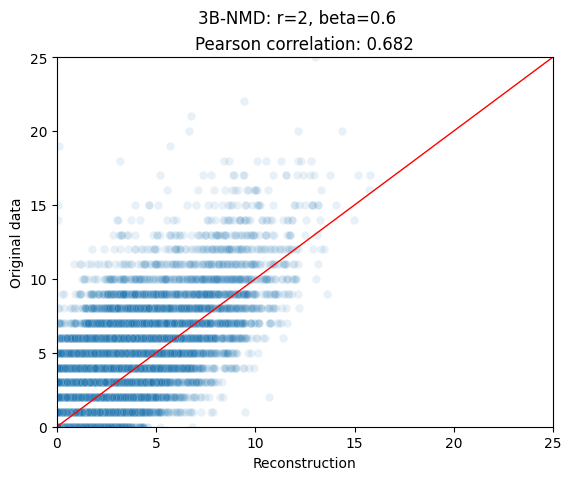

In [50]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b), X_nmd, "3B-NMD: r=2, beta=0.6", type="scatter", sample_fraction=None)

## NMD-T

In [51]:
k_opt_t = 3
beta_opt_t = 0.8

In [52]:
Theta_t, W_t, H_t, loss_t, iters_t, times_t = nmd.nmd_t(X_nmd, r=k_opt_t, W0=W0, H0=H0, beta1=beta_opt_t, tol_over_10iters=1e-4)

Running NMD-T, evolution of [iteration number : relative error in %] - time per iteration
[0 : 74.826786] - 0.332162 secs
[1 : 74.391004] - 0.324216 secs
[2 : 74.106555] - 0.327767 secs
[3 : 74.231041] - 0.323495 secs
[4 : 74.655357] - 0.325551 secs
[5 : 74.716729] - 0.326059 secs
[6 : 74.403702] - 0.324545 secs
[7 : 74.040027] - 0.327250 secs
[8 : 73.698282] - 0.330365 secs
[9 : 73.597446] - 0.323295 secs
[10 : 73.608853] - 0.328678 secs
[11 : 73.527532] - 0.326837 secs
[12 : 73.522660] - 0.324058 secs
[13 : 73.498729] - 0.325477 secs
[14 : 73.426304] - 0.329865 secs
[15 : 73.449275] - 0.324605 secs
[16 : 73.446551] - 0.328626 secs
[17 : 73.407623] - 0.326324 secs
[18 : 73.446726] - 0.325216 secs
[19 : 73.434637] - 0.326650 secs
[20 : 73.405216] - 0.328238 secs
[21 : 73.434838] - 0.320503 secs
[22 : 73.409806] - 0.326054 secs
[23 : 73.392004] - 0.327491 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 73.43478825515653%, after 25 iterations.
Initial

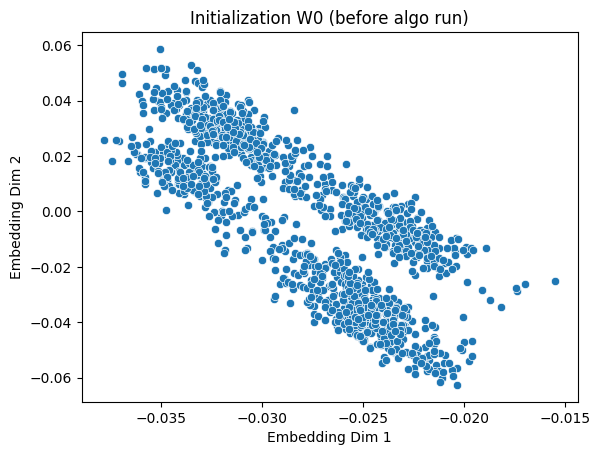

In [53]:
sns.scatterplot(x=W0[:,0], y=W0[:,1]).set(title="Initialization W0 (before algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

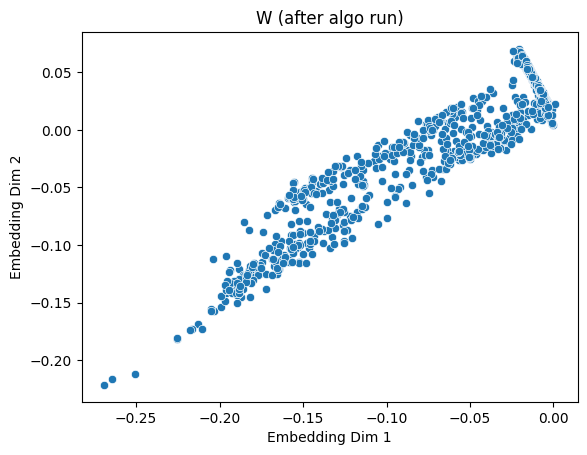

In [54]:
sns.scatterplot(x=W_t[:,0], y=W_t[:,1]).set(title="W (after algo run)", xlabel = "Embedding Dim 1", ylabel = "Embedding Dim 2")
plt.show()

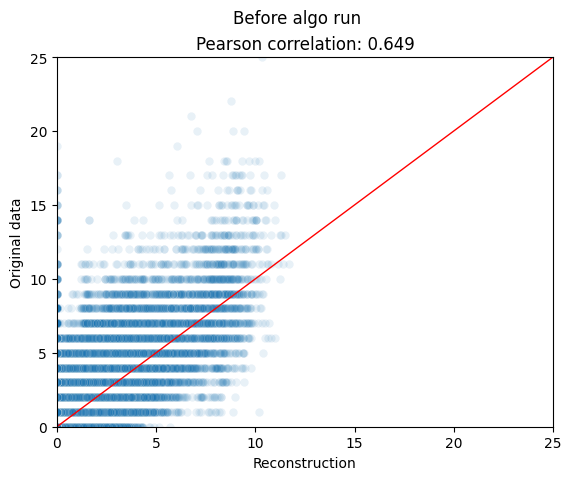

In [55]:
nmd_plot.plot_reconstruction(np.maximum(0, W0@H0), X_nmd, "Before algo run", type="scatter", sample_fraction=None)

In [56]:
spearmanr(np.maximum(0, W0@H0).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.3808790998928788, pvalue=0.0)

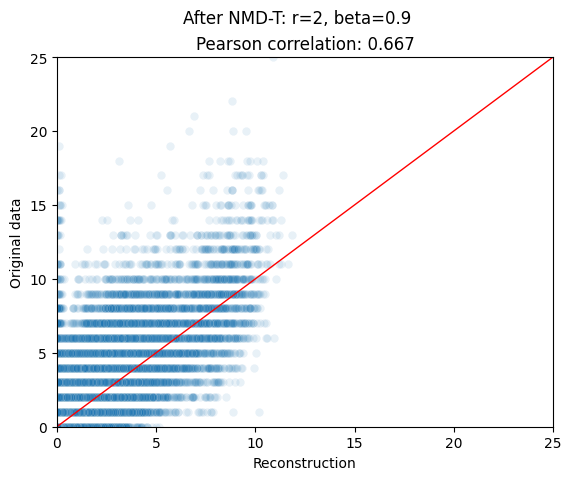

In [57]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_t), X_nmd, "After NMD-T: r=2, beta=0.9", type="scatter", sample_fraction=None)

In [58]:
spearmanr(np.maximum(0, Theta_t).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.3925396379811078, pvalue=0.0)

## NMD-3B - latent dim 5

In [59]:
k_opt_3b5 = 5
beta_opt_3b5 = 0.9
data_layer = "normalized_counts"

In [60]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0_3b5, H0_3b5 = cs.nuclear_norm_init(X_nmd, m, n, k_opt_3b5)
Theta0_3b5 = W0_3b5 @ H0_3b5

In [61]:
Theta_3b5, W_3b5, H_3b5, loss_3b5, iters_3b5, times_3b5 = nmd.nmd_3b(X_nmd, r=k_opt_3b5, W0=W0_3b5, H0=H0_3b5, beta1=beta_opt_3b5, tol_over_10iters=1e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 71.903084] - 0.310146 secs
[1 : 71.776542] - 0.312413 secs
[2 : 71.750802] - 0.311259 secs
[3 : 72.292536] - 0.312215 secs
[4 : 72.397601] - 0.315149 secs
[5 : 72.549063] - 0.313507 secs
[6 : 72.901140] - 0.312952 secs
[7 : 72.990241] - 0.315329 secs
[8 : 72.961198] - 0.310470 secs
[9 : 72.921299] - 0.312545 secs
[10 : 72.731719] - 0.311740 secs
[11 : 72.480253] - 0.308186 secs
[12 : 72.344408] - 0.309609 secs
[13 : 72.253279] - 0.313800 secs
[14 : 72.147898] - 0.307954 secs
[15 : 72.148549] - 0.310221 secs
[16 : 72.086776] - 0.310199 secs
[17 : 72.037907] - 0.306731 secs
[18 : 72.025888] - 0.308857 secs
[19 : 71.981596] - 0.308968 secs
[20 : 71.945599] - 0.306410 secs
[21 : 71.944646] - 0.307843 secs
[22 : 71.901919] - 0.310676 secs
[23 : 71.866409] - 0.308203 secs
[24 : 71.850032] - 0.308810 secs
[25 : 71.829178] - 0.310341 secs
[26 : 71.804003] - 0.307830 secs
[27 : 71.807523] - 0.309657 

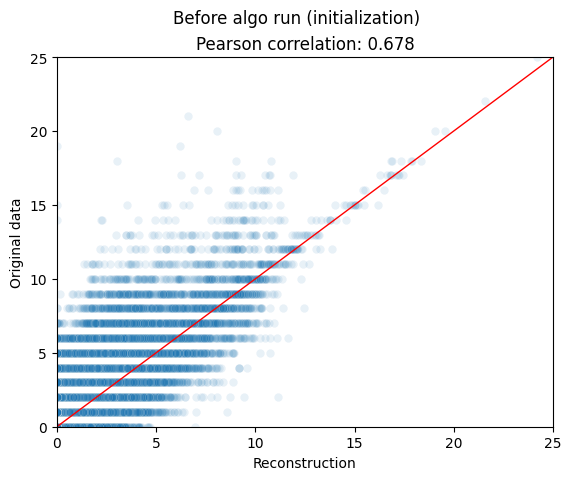

In [62]:
nmd_plot.plot_reconstruction(np.maximum(0, W0_3b5@H0_3b5), X_nmd, "Before algo run (initialization)", type="scatter", sample_fraction=None)

In [63]:
spearmanr(np.maximum(0, W0_3b5@H0_3b5).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.39070497605540927, pvalue=0.0)

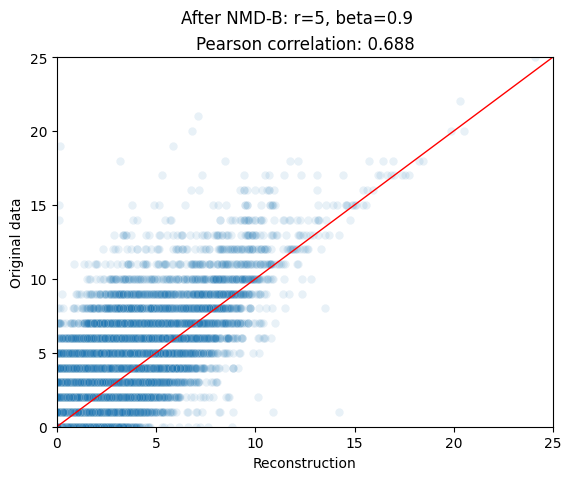

In [64]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_3b5), X_nmd, "After NMD-B: r=5, beta=0.9", type="scatter", sample_fraction=None)

In [65]:
spearmanr(np.maximum(0, Theta_3b5).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.39692874395296773, pvalue=0.0)

## A-NMD Search

In [66]:
k_devs, opt_k_anmd = cs.select_anmd_params_countsplit(data_train, data_test, potential_ks=ks_2_check, layer=data_layer, beta=0.9, do_warmstart=True)

################## LATENT DIM 15
Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 79.257383] - 0.558740 secs
[1 : 80.169983] - 0.564140 secs
[2 : 91.858429] - 0.694783 secs
[3 : 78.911485] - 0.695985 secs
[4 : 78.035839] - 0.696007 secs
[5 : 77.566922] - 0.694659 secs
[6 : 77.251245] - 0.694681 secs
[7 : 77.012825] - 0.696009 secs
[8 : 76.886272] - 0.696580 secs
[9 : 76.941610] - 0.703615 secs
[10 : 76.809815] - 0.693877 secs
[11 : 76.591378] - 0.697738 secs
[12 : 76.446136] - 0.699213 secs
[13 : 76.336967] - 0.696561 secs
[14 : 76.236767] - 0.696718 secs
[15 : 76.136766] - 0.698757 secs
[16 : 76.047171] - 0.701435 secs
[17 : 75.998423] - 0.701024 secs
[18 : 75.968642] - 0.697953 secs
[19 : 75.923816] - 0.701550 secs
[20 : 75.863279] - 0.702236 secs
[21 : 75.792435] - 0.699757 secs
[22 : 75.715541] - 0.699998 secs
[23 : 75.640210] - 0.699984 secs
[24 : 75.575090] - 0.703047 secs
[25 : 75.517028] - 0.701014 secs
[26 : 75.468690] - 0.697206 s

Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 139.430017] - 0.517110 secs
[1 : 195.013917] - 0.517432 secs
[2 : 441.517574] - 0.652110 secs
[3 : 117.081885] - 0.650960 secs
[4 : 109.188759] - 0.648356 secs
[5 : 106.240237] - 0.647595 secs
[6 : 105.096731] - 0.653194 secs
[7 : 104.645219] - 0.650085 secs
[8 : 104.465549] - 0.648326 secs
[9 : 104.393851] - 0.648696 secs
[10 : 104.365200] - 0.657136 secs
[11 : 104.353744] - 0.656551 secs
[12 : 104.349162] - 0.661498 secs
[13 : 104.347329] - 0.660333 secs
[14 : 104.346596] - 0.648772 secs
[15 : 104.346303] - 0.652375 secs
[16 : 104.346186] - 0.657815 secs
[17 : 104.346139] - 0.647376 secs
[18 : 104.346120] - 0.650181 secs
[19 : 104.346113] - 0.651392 secs
[20 : 104.346110] - 0.648282 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 104.34610853568445%, after 22 iterations.
Initialization time: 0.181074 secs
Mean time per iteration: 0.639313 secs
Total time

[179 : 79.706099] - 0.648898 secs
[180 : 79.701447] - 0.647282 secs
[181 : 79.695544] - 0.644190 secs
[182 : 79.690840] - 0.650284 secs
[183 : 79.686004] - 0.646383 secs
[184 : 79.682669] - 0.648713 secs
[185 : 79.682517] - 0.649153 secs
[186 : 79.680425] - 0.648082 secs
[187 : 79.678572] - 0.655013 secs
[188 : 79.676885] - 0.653321 secs
[189 : 79.674909] - 0.652356 secs
[190 : 79.672111] - 0.646416 secs
[191 : 79.668795] - 0.648769 secs
[192 : 79.665488] - 0.653201 secs
[193 : 79.662339] - 0.658860 secs
[194 : 79.659458] - 0.641259 secs
[195 : 79.657139] - 0.645780 secs
[196 : 79.655740] - 0.651242 secs
[197 : 79.655415] - 0.650958 secs
[198 : 79.654320] - 0.652268 secs
[199 : 79.653342] - 0.643044 secs
[200 : 79.652420] - 0.649746 secs
[201 : 79.651422] - 0.653099 secs
[202 : 79.650171] - 0.649398 secs
[203 : 79.648556] - 0.648498 secs
[204 : 79.648142] - 0.655145 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 79.64741459890891%, after 206 iterat

[149 : 82.737992] - 0.668676 secs
[150 : 82.731145] - 0.655938 secs
[151 : 82.724819] - 0.659620 secs
[152 : 82.719746] - 0.650035 secs
[153 : 82.712895] - 0.660832 secs
[154 : 82.705994] - 0.663266 secs
[155 : 82.700474] - 0.663100 secs
[156 : 82.693928] - 0.654658 secs
[157 : 82.689230] - 0.655719 secs
[158 : 82.686924] - 0.668505 secs
[159 : 82.684275] - 0.665798 secs
[160 : 82.680896] - 0.651386 secs
[161 : 82.678723] - 0.658585 secs
[162 : 82.675998] - 0.662822 secs
[163 : 82.673587] - 0.676618 secs
[164 : 82.670486] - 0.657359 secs
[165 : 82.668049] - 0.655768 secs
[166 : 82.664671] - 0.660703 secs
[167 : 82.661145] - 0.667477 secs
[168 : 82.658435] - 0.658918 secs
[169 : 82.656093] - 0.656927 secs
[170 : 82.655649] - 0.665040 secs
[171 : 82.653933] - 0.666977 secs
[172 : 82.653065] - 0.659712 secs
[173 : 82.652102] - 0.659158 secs
[174 : 82.651047] - 0.668825 secs
[175 : 82.649443] - 0.662200 secs
[176 : 82.647476] - 0.660349 secs
[177 : 82.646585] - 0.662851 secs
[178 : 82.6465

In [67]:
opt_k_anmd

4

<Axes: >

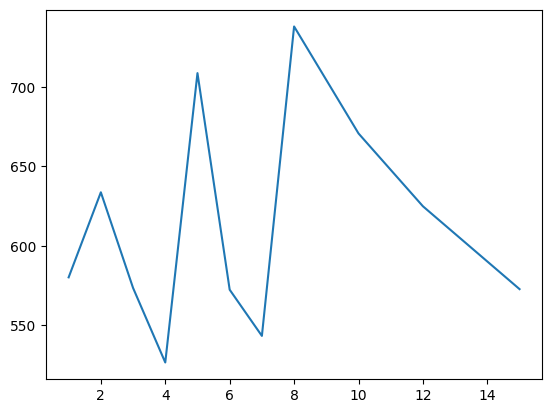

In [87]:
sns.lineplot(x=ks_2_check, y=k_devs)

In [68]:
m, n = data_gene.X.shape
X_nmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_nmd.shape
W0_anmd, H0_anmd = cs.nuclear_norm_init(X_nmd, m, n, opt_k_anmd)
Theta0_anmd = W0_anmd @ H0_anmd

In [69]:
Theta_anmd, loss_anmd, iters_anmd, times_anmd = nmd.a_nmd(X_nmd, r=opt_k_anmd, Theta0=Theta0_anmd, beta=0.9, tol_over_10iters=1e-5)

Running A-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 72.614959] - 0.532439 secs
[1 : 72.666542] - 0.539269 secs
[2 : 75.418918] - 0.676330 secs
[3 : 72.445695] - 0.676671 secs
[4 : 71.832953] - 0.677774 secs
[5 : 71.465035] - 0.674682 secs
[6 : 71.285483] - 0.679360 secs
[7 : 71.204767] - 0.678523 secs
[8 : 71.153480] - 0.683686 secs
[9 : 71.107135] - 0.680837 secs
[10 : 71.053399] - 0.691728 secs
[11 : 70.991186] - 0.690580 secs
[12 : 70.927277] - 0.679783 secs
[13 : 70.875360] - 0.682974 secs
[14 : 70.862347] - 0.683752 secs
[15 : 70.845637] - 0.669913 secs
[16 : 70.819017] - 0.671873 secs
[17 : 70.806393] - 0.673984 secs
[18 : 70.798241] - 0.678245 secs
[19 : 70.791358] - 0.676157 secs
[20 : 70.784807] - 0.667018 secs
[21 : 70.778424] - 0.675706 secs
[22 : 70.772101] - 0.680244 secs
[23 : 70.765754] - 0.678780 secs
[24 : 70.759420] - 0.676026 secs
[25 : 70.752746] - 0.679388 secs
[26 : 70.746657] - 0.684821 secs
[27 : 70.745784] - 0.678448 s

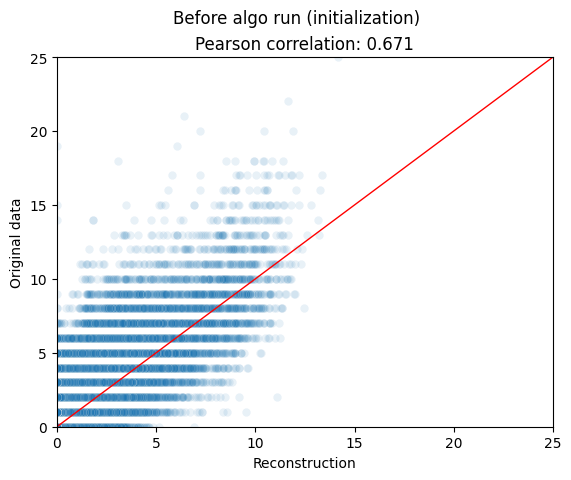

In [70]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta0_anmd), X_nmd, "Before algo run (initialization)", type="scatter", sample_fraction=None)

In [71]:
spearmanr(np.maximum(0, Theta0_anmd).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.39001413786613365, pvalue=0.0)

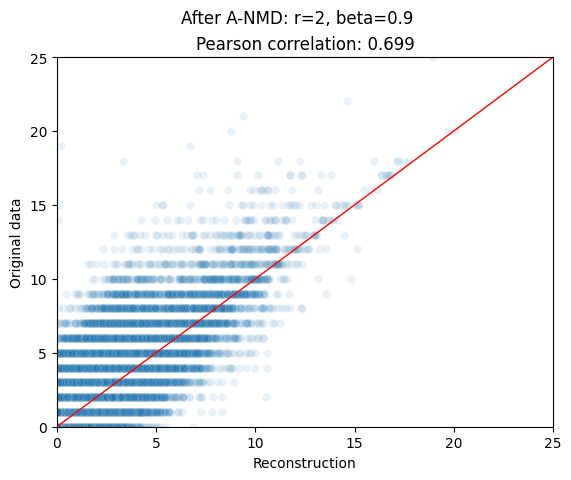

In [72]:
nmd_plot.plot_reconstruction(np.maximum(0, Theta_anmd), X_nmd, "After A-NMD: r=2, beta=0.9", type="scatter", sample_fraction=None)

In [73]:
spearmanr(np.maximum(0, Theta_anmd).flatten().round(0), X_nmd.flatten())

SignificanceResult(statistic=0.4044250061116727, pvalue=0.0)

## A-NMD with beta 0